In [12]:
import pandas as pd
import ast
import os,sys

# --- Read File Selection ---
try:
    read_file = input("Enter read file path (e.g., raw_stream/raw_data_x.csv): ").strip()
    if not read_file or not os.path.isfile(read_file):
        raise FileNotFoundError(f"Read file does not exist: {read_file}")
except Exception as e:
    print(f"[ERROR] {e}")
    sys.exit(1)

# --- Write File Selection ---
try:
    write_file = input("Enter write file path (e.g., processed_stream/processed_data_x.csv): ").strip()
    if not write_file:
        raise ValueError("No write file path provided.")
    write_dir = os.path.dirname(write_file) or "."
    os.makedirs(write_dir, exist_ok=True)  # create parent dirs if needed
    if os.path.exists(write_file):
        os.remove(write_file)
        print(f"[INFO] Existing file '{write_file}' deleted.")
except Exception as e:
    print(f"[ERROR] {e}")
    sys.exit(1)

# --- Processing Logic ---
frames = []

for chunk in pd.read_csv(read_file, usecols=["times", "PM2.5", "PM10", "O3"], dtype=str, chunksize=50_000):
    chunk = chunk[(chunk['times'] != 'times') & (chunk["PM2.5"] != "PM2.5") & (chunk["PM10"] != "PM10") & (chunk["O3"] != "O3")].reset_index(drop=True)
    chunk['times'] = chunk['times'].apply(ast.literal_eval)
    chunk['PM2.5'] = chunk['PM2.5'].apply(ast.literal_eval)
    chunk['PM10'] = chunk['PM10'].apply(ast.literal_eval)
    chunk['O3'] = chunk['O3'].apply(ast.literal_eval)
    chunk = chunk.explode(['times', 'PM2.5', 'PM10', 'O3'], ignore_index=True)
    chunk['times'] = pd.to_datetime(chunk['times'], errors='coerce')
    chunk['PM2.5'] = pd.to_numeric(chunk['PM2.5'], errors='coerce')
    chunk['PM10'] = pd.to_numeric(chunk['PM10'], errors='coerce')
    chunk['O3'] = pd.to_numeric(chunk['O3'], errors='coerce')
    chunk = chunk.dropna(subset=['times', 'PM2.5', 'PM10', 'O3'])
    chunk['hour'] = chunk['times'].dt.floor('h')
    hourly = (
        chunk.groupby('hour', as_index=False)[['PM2.5', 'PM10', 'O3']]
        .mean()
        .rename(columns={
            'PM2.5': 'pm25_mean',
            'PM10': 'pm10_mean',
            'O3': 'o3_mean'
        })
    )
    frames.append(hourly)

df = pd.concat(frames)
df.to_csv(write_file, index=False)
print(f"Processed data saved to: {write_file}")

Processed data saved to: processed_stream/processed_data_2502.csv


In [13]:
import pandas as pd

file1 = "processed_stream/processed_data_2412.csv"
file2 = "processed_stream/processed_data_2501.csv"
file3 = "processed_stream/processed_data_2502.csv"

# Read each CSV into a DataFrame
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Concatenate all three
df = pd.concat([df1, df2, df3], ignore_index=True)

In [14]:
df_c = df.copy()

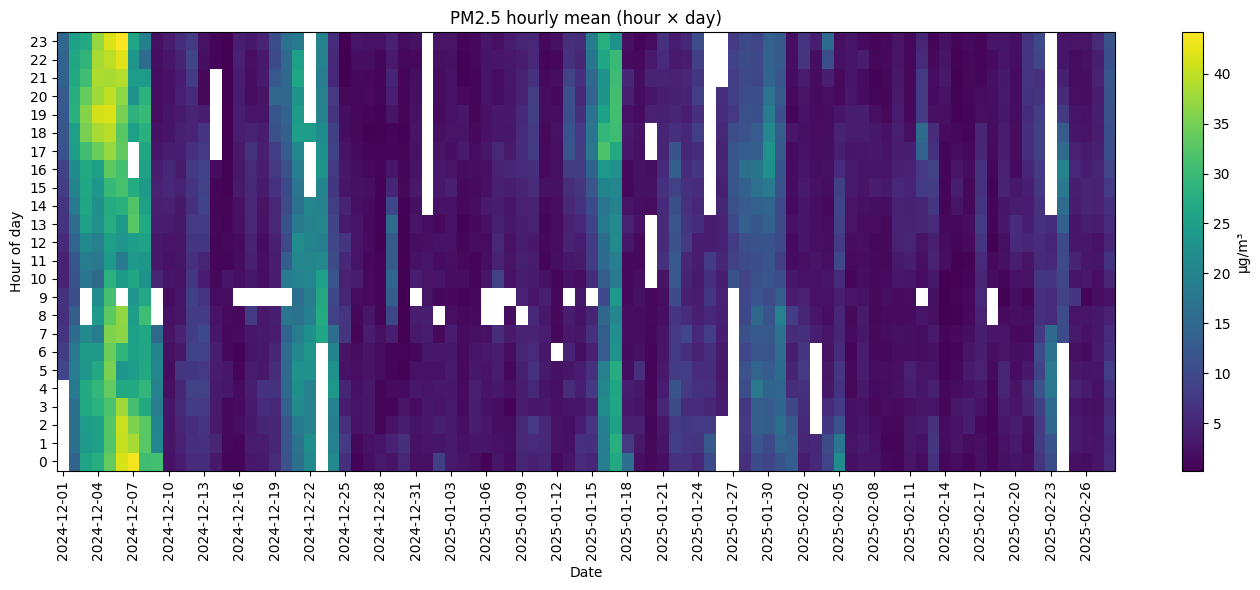

In [15]:
import matplotlib.pyplot as plt
import numpy as np

df['hour'] = pd.to_datetime(df['hour'], errors='coerce')

# split into date + hour-of-day
df['date'] = df['hour'].dt.date
df['hod']  = df['hour'].dt.hour

g = df.groupby(['date','hod'], as_index=False)['pm25_mean'].mean()

heat = (
    g.pivot(index='hod', columns='date', values='pm25_mean')
     .sort_index()
)
# plot (matplotlib, no explicit colors)
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(heat.to_numpy(), aspect='auto', origin='lower')

ax.set_yticks(np.arange(heat.shape[0]))
ax.set_yticklabels(heat.index)

cols = heat.columns
step = max(1, len(cols)//30)
ax.set_xticks(np.arange(0, len(cols), step))
ax.set_xticklabels([c.strftime('%Y-%m-%d') for c in cols[::step]], rotation=90)

ax.set_xlabel('Date'); ax.set_ylabel('Hour of day')
ax.set_title('PM2.5 hourly mean (hour × day)')
fig.colorbar(im, ax=ax, label='µg/m³')
fig.tight_layout(); plt.show()


In [4]:
import pandas as pd
import plotly.express as px

df = df_c.copy()
df['hour'] = pd.to_datetime(df['hour'], errors='coerce')
df['date'] = df['hour'].dt.date
df['hod']  = df['hour'].dt.hour

g = df.groupby(['date','hod'], as_index=False)['pm25_mean'].mean()

# Pivot for heatmap
heat = g.pivot(index='hod', columns='date', values='pm25_mean').sort_index()

# Convert to long format for Plotly
heat_long = heat.reset_index().melt(id_vars='hod', var_name='date', value_name='pm25_mean')

fig = px.imshow(
    heat.values,
    labels=dict(x="Date", y="Hour of Day", color="PM2.5 (µg/m³)"),
    x=[d.strftime('%Y-%m-%d') for d in heat.columns],
    y=heat.index,
    aspect="auto",
    color_continuous_scale="Viridis"
)
fig.update_layout(title="Interactive PM2.5 Heatmap (Hour × Day)")
fig.show()



In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- 1) Ensure df['hour'] is datetime ---
# If it's already datetime, this is a no-op. If it's a string/number, it will parse it.
df = df.copy()
df['hour'] = pd.to_datetime(df['hour'], errors='coerce')

# Drop rows that failed to parse
df = df.dropna(subset=['hour'])

# --- 2) Derive date and hour-of-day ---
df['date'] = df['hour'].dt.normalize()     # midnight for each date (datetime64[ns])
df['hod']  = df['hour'].dt.hour            # 0..23

# --- 3) Build pivot: rows = hour-of-day, cols = date, values = pm25_mean ---
heat = (
    df.pivot_table(index='hod', columns='date', values='pm25_mean', aggfunc='mean')
      .sort_index()
)

# If columns are date objects (rare), convert to datetime for nicer axis formatting
if not np.issubdtype(heat.columns.dtype, np.datetime64):
    heat.columns = pd.to_datetime(heat.columns)

# --- 4) Classify danger levels (heuristic) ---
bins  = [-np.inf, 12.0, 35.4, 55.4, 150.4, np.inf]
names = ["Good", "Moderate", "USG", "Unhealthy", "Very Unhealthy"]

vals = heat.values
cat_idx = np.digitize(vals, bins) - 1
cat_idx = np.clip(cat_idx, 0, len(names)-1)

custom = np.where(
    np.isnan(vals),
    "No data",
    np.array(names, dtype=object)[cat_idx]
)

# --- 5) Interactive heatmap ---
fig = px.imshow(
    heat,
    origin="lower",
    aspect="auto",
    labels=dict(x="Date", y="Hour of day", color="µg/m³"),
    x=heat.columns, y=heat.index,
    color_continuous_scale="Viridis",
)

# Attach 2-D customdata matching z-shape
fig.update_traces(
    customdata=custom,
    hovertemplate="Date=%{x|%Y-%m-%d}<br>Hour=%{y}:00<br>PM2.5=%{z:.1f} µg/m³<br>Status=%{customdata}<extra></extra>"
)

fig.update_layout(
    title="PM2.5 hourly mean (interactive heatmap)",
    xaxis_tickangle=-45,
    yaxis_nticks=24,
)
fig.show()


In [5]:
df = df_c.copy()
df['hour'] = pd.to_datetime(df['hour'], errors='coerce')
df = df.sort_values('hour')
df['pm25_delta'] = df['pm25_mean'].diff()

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['hour'],
    y=df['pm25_mean'],
    mode='lines+markers',
    name='PM2.5',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=df['hour'],
    y=df['pm25_delta'],
    mode='lines',
    name='Δ PM2.5',
    line=dict(color='red', dash='dot')
))

fig.update_layout(
    title="PM2.5 Levels and Increments Over Time",
    xaxis_title="Timestamp",
    yaxis_title="µg/m³",
    hovermode="x unified"
)
fig.show()


In [23]:
import plotly.subplots as sp
import plotly.graph_objects as go

df = df_c.copy()

fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True,
                       subplot_titles=["PM2.5", "PM10", "O₃"],
                       vertical_spacing=0.05)

fig.add_trace(go.Scatter(x=df['hour'], y=df['pm25_mean'],
                         mode='lines+markers', name='PM2.5',
                         line=dict(color='indigo')), row=1, col=1)

fig.add_trace(go.Scatter(x=df['hour'], y=df['pm10_mean'],
                         mode='lines+markers', name='PM10',
                         line=dict(color='crimson')), row=2, col=1)

fig.add_trace(go.Scatter(x=df['hour'], y=df['o3_mean'],
                         mode='lines+markers', name='O₃',
                         line=dict(color='teal')), row=3, col=1)

fig.update_layout(height=600, width=1200, title="Pollutant Trends Over Time",
                  xaxis3_title="Timestamp", yaxis_title="µg/m³",
                  hovermode="x unified", template="plotly_white")
fig.show()
